<a href="https://colab.research.google.com/github/Hrishikesh182001/Hrishikesh182001/blob/main/Trader_Behavior_vs_Market_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

📂 Please select your CSV files: historical_data.csv and fear_greed_index.csv


Saving historical_data.csv to historical_data.csv
Saving fear_greed_index.csv to fear_greed_index.csv


/tmp/ipython-input-2461901732.py:75: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged["Classification"] = merged["Classification"].fillna(method="ffill").fillna(method="bfill")


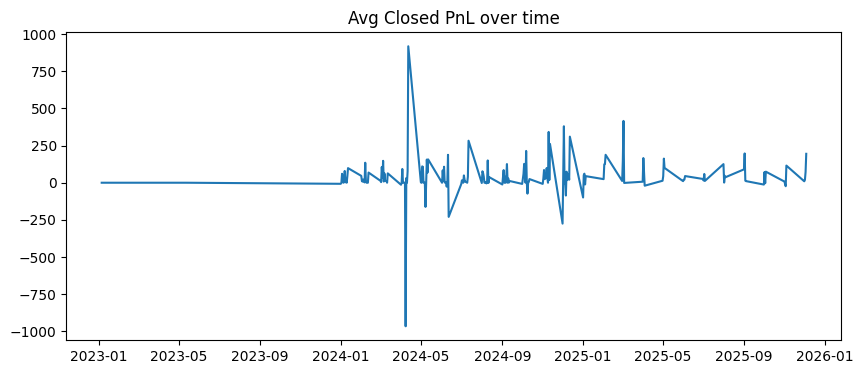

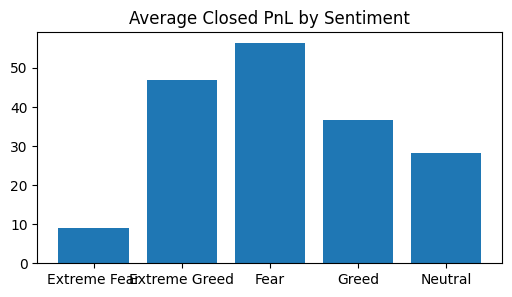

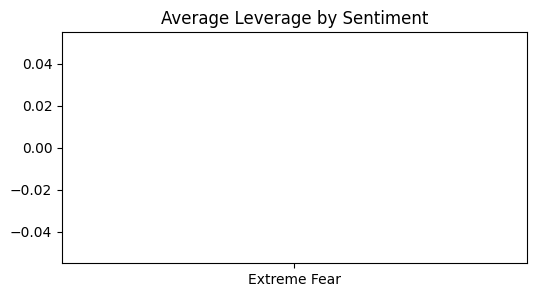

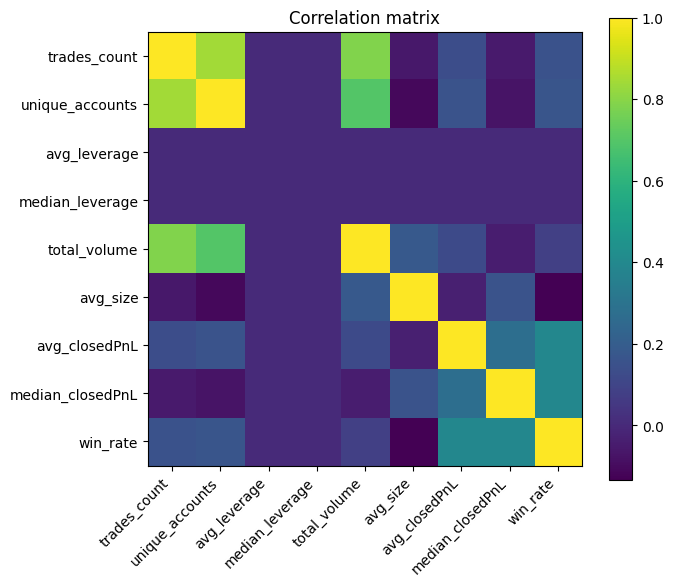

✅ Analysis complete!
CSV outputs saved in: ds_hrishikesh/csv_files
Charts saved in: ds_hrishikesh/outputs


In [2]:

from google.colab import files
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

BASE_DIR = "ds_hrishikesh"
CSV_DIR = os.path.join(BASE_DIR, "csv_files")
OUT_DIR = os.path.join(BASE_DIR, "outputs")
os.makedirs(CSV_DIR, exist_ok=True)
os.makedirs(OUT_DIR, exist_ok=True)

print("📂 Please select your CSV files: historical_data.csv and fear_greed_index.csv")
uploaded = files.upload()

# Move uploaded files into csv_files folder
for fname in uploaded.keys():
    os.rename(fname, os.path.join(CSV_DIR, fname))

# Paths
HIST_PATH = os.path.join(CSV_DIR, "historical_data.csv")
SENT_PATH = os.path.join(CSV_DIR, "fear_greed_index.csv")

# 2) Load data
df_tr = pd.read_csv(HIST_PATH)
df_sent = pd.read_csv(SENT_PATH)

# 3) Map actual column names
account_col = [c for c in df_tr.columns if "account" in c.lower()][0]
size_col = [c for c in df_tr.columns if "size usd" in c.lower()][0]
pnl_col = [c for c in df_tr.columns if "pnl" in c.lower()][0]
time_col = [c for c in df_tr.columns if "timestamp" in c.lower() or "time" in c.lower()][0]

# 4) Clean trader data
df_tr["time_parsed"] = pd.to_datetime(df_tr[time_col], errors="coerce")
df_tr["size"] = pd.to_numeric(df_tr[size_col], errors="coerce")
df_tr["closedPnL"] = pd.to_numeric(df_tr[pnl_col], errors="coerce")
df_tr["leverage"] = np.nan  # not in dataset
df_tr = df_tr[~df_tr["time_parsed"].isna()].copy()
df_tr["trade_date"] = df_tr["time_parsed"].dt.date

# 5) Daily aggregation
def compute_daily_trader_metrics(df):
    return df.groupby("trade_date").agg(
        trades_count=("time_parsed", "count"),
        unique_accounts=(account_col, "nunique"),
        avg_leverage=("leverage", "mean"),
        median_leverage=("leverage", "median"),
        total_volume=("size", "sum"),
        avg_size=("size", "mean"),
        avg_closedPnL=("closedPnL", "mean"),
        median_closedPnL=("closedPnL", "median"),
        win_rate=("closedPnL", lambda x: (x > 0).sum() / len(x) if len(x) > 0 else np.nan)
    ).reset_index()

daily_tr = compute_daily_trader_metrics(df_tr)

# 6) Clean sentiment data
sent_date_col = [c for c in df_sent.columns if "date" in c.lower()][0]
df_sent["Date"] = pd.to_datetime(df_sent[sent_date_col], errors="coerce")
class_cols = [c for c in df_sent.columns if "class" in c.lower() or "fear" in c.lower() or "greed" in c.lower()]
if class_cols:
    df_sent["Classification"] = df_sent[class_cols[0]].astype(str).str.strip().str.title()
else:
    score_cols = [c for c in df_sent.columns if "score" in c.lower() or "value" in c.lower()]
    if score_cols:
        df_sent["Classification"] = np.where(df_sent[score_cols[0]] >= df_sent[score_cols[0]].median(), "Greed", "Fear")
    else:
        df_sent["Classification"] = "Fear"
df_sent["sent_date"] = df_sent["Date"].dt.date

# 7) Merge
daily_tr["sent_date"] = daily_tr["trade_date"]
merged = pd.merge(daily_tr, df_sent[["sent_date", "Classification"]], on="sent_date", how="left")
merged["Classification"] = merged["Classification"].fillna(method="ffill").fillna(method="bfill")

# 8) Summary by sentiment
summary_by_sent = merged.groupby("Classification").agg(
    days=("trade_date", "nunique"),
    avg_leverage=("avg_leverage", "mean"),
    avg_closedPnL=("avg_closedPnL", "mean"),
    avg_win_rate=("win_rate", "mean"),
    avg_volume=("total_volume", "mean")
).reset_index()
summary_by_sent.to_csv(os.path.join(CSV_DIR, "summary_by_sentiment.csv"), index=False)

# 9) Time series & bar charts
plt.figure(figsize=(10,4))
plt.plot(merged["trade_date"], merged["avg_closedPnL"])
plt.title("Avg Closed PnL over time")
plt.savefig(os.path.join(OUT_DIR, "ts_avg_closedPnL.png"))
plt.show()

plt.figure(figsize=(6,3))
plt.bar(summary_by_sent["Classification"], summary_by_sent["avg_closedPnL"])
plt.title("Average Closed PnL by Sentiment")
plt.savefig(os.path.join(OUT_DIR, "avg_closedPnL_by_sent.png"))
plt.show()

plt.figure(figsize=(6,3))
plt.bar(summary_by_sent["Classification"], summary_by_sent["avg_leverage"])
plt.title("Average Leverage by Sentiment")
plt.savefig(os.path.join(OUT_DIR, "avg_leverage_by_sent.png"))
plt.show()

# 10) Correlation matrix
num_cols = ["trades_count","unique_accounts","avg_leverage","median_leverage","total_volume","avg_size","avg_closedPnL","median_closedPnL","win_rate"]
num_cols = [c for c in num_cols if c in merged.columns]
corr = merged[num_cols].corr().fillna(0)
plt.figure(figsize=(7,6))
plt.imshow(corr, cmap="viridis")
plt.colorbar()
plt.xticks(range(len(num_cols)), num_cols, rotation=45, ha="right")
plt.yticks(range(len(num_cols)), num_cols)
plt.title("Correlation matrix")
plt.savefig(os.path.join(OUT_DIR, "correlation_matrix.png"))
plt.show()

# 11) Lag analysis
merged_sorted = merged.sort_values("trade_date").reset_index(drop=True)
merged_sorted["leverage_next_day"] = merged_sorted["avg_leverage"].shift(-1)
merged_sorted["winrate_next_day"] = merged_sorted["win_rate"].shift(-1)
lag_summary = merged_sorted.groupby("Classification").agg(
    days=("trade_date", "count"),
    next_avg_leverage=("leverage_next_day", "mean"),
    next_win_rate=("winrate_next_day", "mean")
).reset_index()
lag_summary.to_csv(os.path.join(CSV_DIR, "lag_summary.csv"), index=False)

# 12) Top-trader segmentation (top 5% by total volume)
acc_vol = df_tr.groupby(account_col).agg(total_volume=("size", "sum")).reset_index()
acc_vol["rank_pct"] = acc_vol["total_volume"].rank(pct=True)
top_accounts = acc_vol.loc[acc_vol["rank_pct"] >= 0.95, account_col].tolist()
df_tr["segment"] = np.where(df_tr[account_col].isin(top_accounts), "Top", "Rest")
seg_agg = df_tr.groupby(["trade_date","segment"]).agg(
    trades_count=(account_col,"count"),
    avg_leverage=("leverage","mean"),
    avg_closedPnL=("closedPnL","mean")
).reset_index()
seg_summary = seg_agg.groupby("segment").agg(
    days=("trade_date","nunique"),
    avg_leverage=("avg_leverage","mean"),
    avg_closedPnL=("avg_closedPnL","mean")
).reset_index()
seg_summary.to_csv(os.path.join(CSV_DIR, "segment_summary.csv"), index=False)

# 13) Save merged dataset
merged.to_csv(os.path.join(CSV_DIR, "daily_merged_summary.csv"), index=False)

print("✅ Analysis complete!")
print("CSV outputs saved in:", CSV_DIR)
print("Charts saved in:", OUT_DIR)
